This notebook addresses requirements [LVV-303](https://jira.lsstcorp.org/browse/LVV-303?filter=23354) and [LVV-304](https://jira.lsstcorp.org/browse/LVV-304?filter=23354),
covered in test cases LVV-T2848 and LVV-T2848.

These requirements define the allowable uncertainty for parallax and proper motion, which is affected by survey strategy due to the timing of the observations. 

In [1]:
import os
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import healpy as hp

import rubin_sim.maf as maf

In [2]:
import rubin_sim
rubin_sim.__version__

'1.3.0'

### Calculate Metrics 

Identify the baseline survey simulation, currently `baseline_v3.2_10yrs`, which is the current example of an implemented survey strategy.

In [3]:
# Download and write to current directory, if does not exist
run_name = 'baseline_v3.2_10yrs'
dbfile = f"{run_name}.db"

url_baseline = "https://s3df.slac.stanford.edu/data/rubin/sim-data/"
url_baseline += "sims_featureScheduler_runs3.2/baseline/baseline_v3.2_10yrs.db"

if not(os.path.isfile(dbfile)):
    print(f'Downloading {run_name} from {url_baseline}')

    from urllib.request import urlopen

    with urlopen(url_baseline) as file:
        content = file.read()
    with open(dbfile, 'wb') as download:
        download.write(content)

print(f"Using {run_name} as the example of the baseline survey strategy.")

Using baseline_v3.2_10yrs as the example of the baseline survey strategy.


Run SRD metrics for parallax and proper motion uncertainties.
These metrics are coded into `rubin_sim.maf`, at https://github.com/lsst/rubin_sim/blob/main/rubin_sim/maf/batches/srd_batch.py
with the individual metrics for Parallax and Proper Motion accuracy at [parallax metrics](https://github.com/lsst/rubin_sim/blob/main/rubin_sim/maf/metrics/calibration_metrics.py#L18) 
and [proper motion](https://github.com/lsst/rubin_sim/blob/main/rubin_sim/maf/metrics/calibration_metrics.py#L143). 

These metrics are written to calculate accuracy in proper motion and parallax, assuming that each can be fit independently. The astrometry metrics also assume that centroid accuracy for each measurement can be approximated by 
```astrometry_err = sqrt ( (seeing / SNR) ** 2 + (systematic floor) ** 2)```
where the systematic noise floor is assumed to be 10 mas (which matches SRD requirements). 

In [4]:
astrometry_bundles = maf.astrometryBatch(colmap=None,
                                        runName=run_name)
list(astrometry_bundles.keys())

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


['baseline_v3_2_10yrs_Parallax_Uncert_@_22_4_All_visits_HEAL',
 'baseline_v3_2_10yrs_Parallax_Uncert_@_24_0_All_visits_HEAL',
 'baseline_v3_2_10yrs_Normalized_Parallax_Uncert_@_22_4_All_visits_HEAL',
 'baseline_v3_2_10yrs_Normalized_Parallax_Uncert_@_24_0_All_visits_HEAL',
 'baseline_v3_2_10yrs_Parallax_Coverage_@_22_4_All_visits_HEAL',
 'baseline_v3_2_10yrs_Parallax_Coverage_@_24_0_All_visits_HEAL',
 'baseline_v3_2_10yrs_Parallax-DCR_degeneracy_@_22_4_All_visits_HEAL',
 'baseline_v3_2_10yrs_Parallax-DCR_degeneracy_@_24_0_All_visits_HEAL',
 'baseline_v3_2_10yrs_Parallax_Uncert_@_21_3_y_band_visits_HEAL',
 'baseline_v3_2_10yrs_Normalized_Parallax_Uncert_@_21_3_y_band_visits_HEAL',
 'baseline_v3_2_10yrs_Proper_Motion_Uncert_@_20_5_All_visits_HEAL',
 'baseline_v3_2_10yrs_Proper_Motion_Uncert_@_24_0_All_visits_HEAL',
 'baseline_v3_2_10yrs_Normalized_Proper_Motion_Uncert_@_20_5_All_visits_HEAL',
 'baseline_v3_2_10yrs_Normalized_Proper_Motion_Uncert_@_24_0_All_visits_HEAL']

In [5]:
out_dir = 'srd_parallax_pm'
results_db = maf.ResultsDb(out_dir)

#calculate_metrics = False
calculate_metrics = True

astrometry_bundles = maf.astrometryBatch(colmap=None,
                                        runName=run_name)

kk = ['baseline_v3_2_10yrs_Parallax_Uncert_@_22_4_All_visits_HEAL', 'baseline_v3_2_10yrs_Parallax_Uncert_@_24_0_All_visits_HEAL']

g = maf.MetricBundleGroup(astrometry_bundles, 
                          dbfile, out_dir=out_dir, results_db=results_db)
if calculate_metrics:
    g.run_all()
    g.write_all()
else:
    g.read_all()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [6]:
# Run with only idealized (SRD) conditions for the seeing and depth 
out_dir = 'srd_parallax_pm_ideal'
results_db = maf.ResultsDb(out_dir)

#calculate_metrics = False
calculate_metrics = True

astrometry_bundles_ideal = maf.astrometryBatch(colmap=None,
                                        runName=run_name)

seeing_srd = {'u': 0.77, 'g': 0.73, 'r': 0.70, 'i' : 0.67, 'z': 0.65, 'y': 0.63}
m5_srd = {'u': 23.90, 'g': 25.0, 'r': 24.70, 'i': 24.0, 'z': 23.3, 'y': 22.1}

import sqlite3
conn = sqlite3.connect(dbfile)
query = 'select * from observations'
dd = pd.read_sql(query, conn)
dd = dd.to_records()
for f in 'ugrizy':
    good = np.where(dd['filter'] == f)
    dd['seeingFwhmGeom'][good] = seeing_srd[f]
    dd['fiveSigmaDepth'][good] = m5_srd[f]


g = maf.MetricBundleGroup(astrometry_bundles_ideal, dbfile, out_dir=out_dir, results_db=results_db)
if calculate_metrics:
    ## all bands
    g.run_current(constraint='', sim_data=dd)
    g.write_all()
    ## y band
    kk = f"{run_name.replace('.', '_')}_Parallax_Uncert_@_21_3_y_band_visits_HEAL"
    sim_data = dd[np.where(dd["filter"] == "y")]
    g.run_current(constraint=astrometry_bundles_ideal[kk].constraint, sim_data=sim_data)
    g.write_all()
else:
    g.read_all()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


### Evaluate Parallax ###

The requirements state that the parallax uncertainty at r=24 should be no more than 3 mas, while the parallax uncertainty for sources measured only in y band at 10$\sigma$ should be less than 6 mas. This is based on an assumed scaling from values at r=22.4, where the parallax uncertainty is expected to be less than 1mas. 

In [7]:
keys = [f"{run_name.replace('.', '_')}_Parallax_Uncert_@_22_4_All_visits_HEAL",
        f"{run_name.replace('.', '_')}_Parallax_Uncert_@_24_0_All_visits_HEAL"]
pd.DataFrame([astrometry_bundles[k].summary_values["Median Parallax Uncert (18k)"] for k in keys], index=keys, columns=['Median Parallax Uncertainty (top 18k)'])

,Median Parallax Uncertainty (top 18k)
baseline_v3_2_10yrs_Parallax_Uncert_@_22_4_All_visits_HEAL,2.345929
baseline_v3_2_10yrs_Parallax_Uncert_@_24_0_All_visits_HEAL,9.417855


With our realistic seeing and depths, we do not (quite) meet the SRD constraints for the parallax uncertainty. HOWEVER, the assumptions on seeing and depth were different when the SRD was written - and the survey strategy can still be good but not meeting requirements due to these updates in weather and expected throughput. 
Thus we should look at the results from the "ideal" metric bundle above. 

In [8]:
keys = [f"{run_name.replace('.', '_')}_Parallax_Uncert_@_22_4_All_visits_HEAL",
        f"{run_name.replace('.', '_')}_Parallax_Uncert_@_24_0_All_visits_HEAL"]
pd.DataFrame([astrometry_bundles_ideal[k].summary_values["Median Parallax Uncert (18k)"] for k in keys], index=keys, columns=['Median Parallax Uncertainty (top 18k)'])

,Median Parallax Uncertainty (top 18k)
baseline_v3_2_10yrs_Parallax_Uncert_@_22_4_All_visits_HEAL,1.317131
baseline_v3_2_10yrs_Parallax_Uncert_@_24_0_All_visits_HEAL,5.031398


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/maf_utils.py:143: UserWarning: Optimal bin calculation tried to make 4134 bins, returning 200
  warnings.warn(


{'SkyMap': 1, 'Histogram': 2}

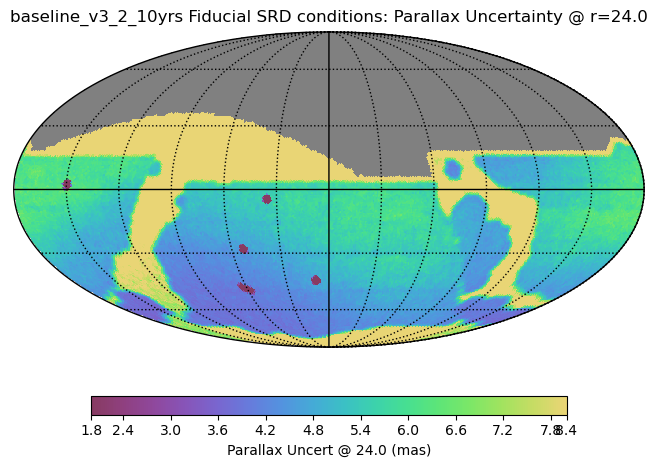

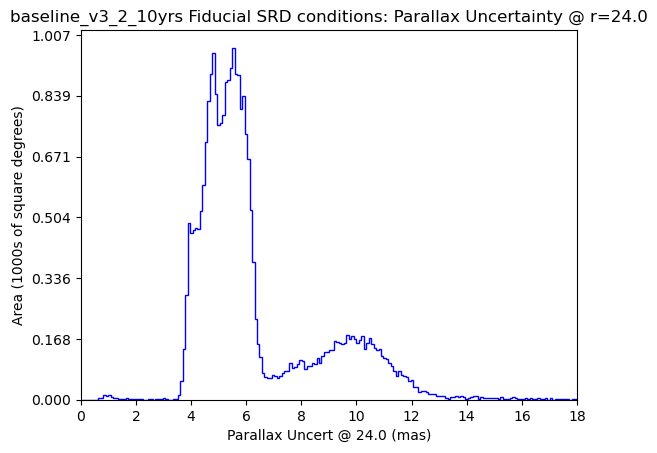

In [9]:
b = astrometry_bundles_ideal[f"{run_name.replace('.', '_')}_Parallax_Uncert_@_24_0_All_visits_HEAL"]
plot_dict = {"title" : f"{run_name.replace('.', '_')} Fiducial SRD conditions: Parallax Uncertainty @ r=24.0",
             "color_min" : 2, "color_max": 8}
b.set_plot_dict(plot_dict)
b.plot()

These are still slightly worse than the design values, but the parallax uncertainty at 24.0 is passing minimum requirements. 

It is also worth looking at the normalized parallax metric results, which compare the estimate parallax uncertainty with the best evaluation of the parallax. For fields in the ecliptic, a flat distribution of visits over a full 365 days per year would result in a value of 0.5 for this comparison; for fields near the pole, a value of 1 indicates the widest possible sampling. In general values closer to 1 are better, and we see that the normalized parallax metric results tend toward 1. 

normalized parallax uncertainty - 1 = matching best possible parallax uncertainty


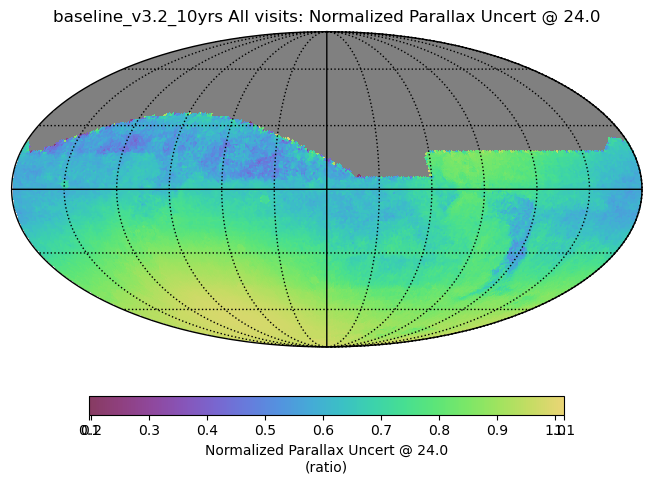

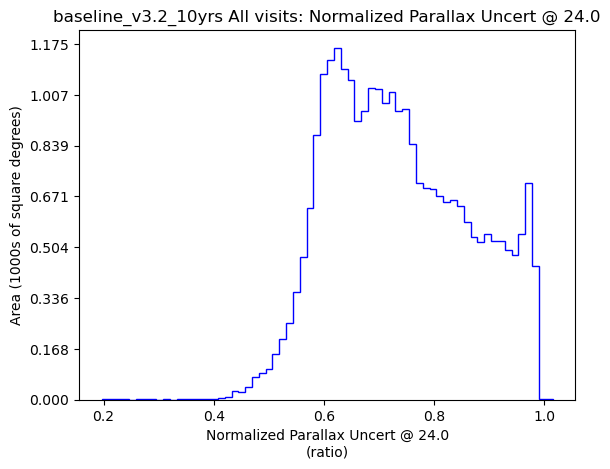

In [10]:
b = astrometry_bundles[f"{run_name.replace('.', '_')}_Normalized_Parallax_Uncert_@_24_0_All_visits_HEAL"]
b.plot()
print("normalized parallax uncertainty - 1 = matching best possible parallax uncertainty")

In [19]:
print("Median parallax uncertainty over the top 18k square degrees (approximately equivalent to the 'WFD') under SRD seeing and depth conditions at r=24.0 is ")
print("SIGpara = %.2f mas " % astrometry_bundles_ideal[f"{run_name.replace('.', '_')}_Parallax_Uncert_@_24_0_All_visits_HEAL"].summary_values["Median Parallax Uncert (18k)"])
print("The design requirement is 3.0 mas, the minimum requirement is 6.0 mas.")

Median parallax uncertainty over the top 18k square degrees (approximately equivalent to the 'WFD') under SRD seeing and depth conditions at r=24.0 is 
SIGpara = 5.03 mas 
The design requirement is 3.0 mas, the minimum requirement is 6.0 mas.


The y-band-only parallax accuracy (SIGparaRed) is an estimate of the parallax accuracy for sources visible in y band only, with a brightness of about 10$\sigma$ in y band. For the same reasons as above, we look at the estimate using idealized seeing and 5$\sigma$ depth conditions.

In [12]:
b = astrometry_bundles_ideal[f"{run_name.replace('.', '_')}_Parallax_Uncert_@_21_3_y_band_visits_HEAL"]
print("Median parallax uncertainty over the top 18k square degrees under SRD seeing and depth conditions, for sources with SNR=10 visible in y band only")
print("SIGparaRed %.2f mas" % b.summary_values["Median Parallax Uncert (18k)"])
print("The design requirement is 6.0 mas, the minimum requirement is 10.0 mas.")

Median parallax uncertainty over the top 18k square degrees under SRD seeing and depth conditions, for sources with SNR=10 visible in y band only
SIGparaRed 6.41 mas
The design requirement is 6.0 mas, the minimum requirement is 10.0 mas.


### Evaluate proper motion ###

The requirements state that the proper motion uncertainty at r=24 should be no more than 1mas, based on an assumed scaling from values at r=20.5 where the proper motion uncertainty is expected to be less than 0.2 mas. 

In [13]:
keys = [f"{run_name.replace('.', '_')}_Proper_Motion_Uncert_@_20_5_All_visits_HEAL",
        f"{run_name.replace('.', '_')}_Proper_Motion_Uncert_@_24_0_All_visits_HEAL"]
pd.DataFrame([astrometry_bundles[k].summary_values["Median Proper Motion Uncert (18k)"] for k in keys], index=keys, columns=['Median Proper Motion Uncertainty (top 18k)'])

,Median Proper Motion Uncertainty (top 18k)
baseline_v3_2_10yrs_Proper_Motion_Uncert_@_20_5_All_visits_HEAL,0.192203
baseline_v3_2_10yrs_Proper_Motion_Uncert_@_24_0_All_visits_HEAL,2.299101


We instead use the estimated proper motion uncertainties that would be achieved using SRD seeing and 5$\sigma$ depths. 

In [14]:
keys = [f"{run_name.replace('.', '_')}_Proper_Motion_Uncert_@_20_5_All_visits_HEAL",
        f"{run_name.replace('.', '_')}_Proper_Motion_Uncert_@_24_0_All_visits_HEAL"]
pd.DataFrame([astrometry_bundles_ideal[k].summary_values["Median Proper Motion Uncert (18k)"] for k in keys], index=keys, columns=['Median Proper Motion Uncertainty (top 18k)'])

,Median Proper Motion Uncertainty (top 18k)
baseline_v3_2_10yrs_Proper_Motion_Uncert_@_20_5_All_visits_HEAL,0.150071
baseline_v3_2_10yrs_Proper_Motion_Uncert_@_24_0_All_visits_HEAL,1.311397


And similarly to the parallax, there is also an evaluation of the proper motion measurement achieved compared to the best possible proper motion measurement (which would occur if half of the observations were at the start of the survey and half at the end .. an unrealistic situation).  We see that most of the sky is observed in a way that comes close to the best possible approach; rolling cadence leaves some impact. 

/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/maf_utils.py:143: UserWarning: Optimal bin calculation tried to make 455 bins, returning 200
  warnings.warn(


normalized proper motion uncertainty - 1 = matching best possible (unrealistic) proper motion uncertainty


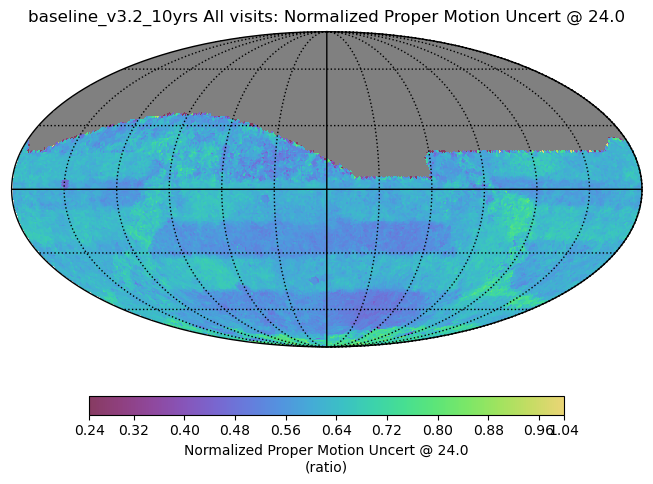

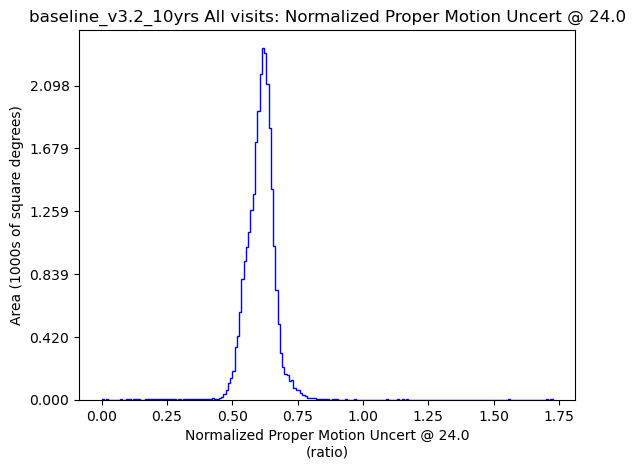

In [15]:
b = astrometry_bundles[f"{run_name.replace('.', '_')}_Normalized_Proper_Motion_Uncert_@_24_0_All_visits_HEAL"]
plot_dict = {"color_min" : 0.25, "color_max": 1}
b.set_plot_dict(plot_dict)
b.plot()
print("normalized proper motion uncertainty - 1 = matching best possible (unrealistic) proper motion uncertainty")

/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/maf_utils.py:143: UserWarning: Optimal bin calculation tried to make 980404000 bins, returning 200
  warnings.warn(


{'SkyMap': 1, 'Histogram': 2}

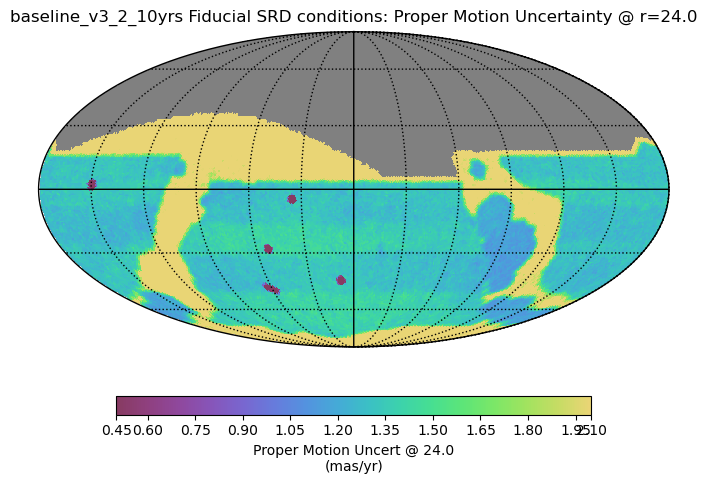

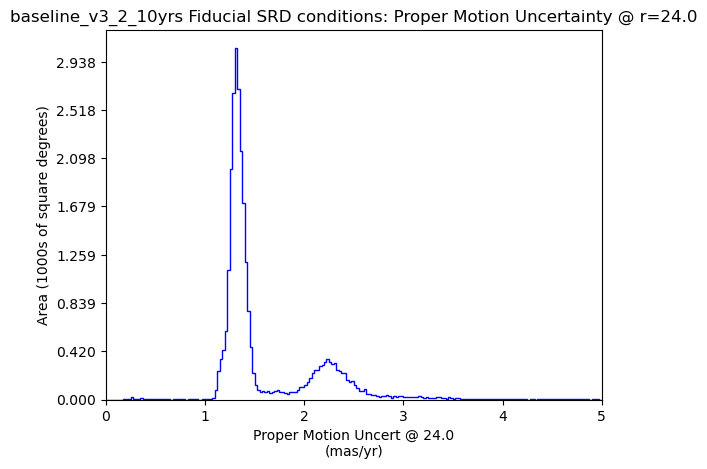

In [16]:
b = astrometry_bundles_ideal[f"{run_name.replace('.', '_')}_Proper_Motion_Uncert_@_24_0_All_visits_HEAL"]
plot_dict = {"title" : f"{run_name.replace('.', '_')} Fiducial SRD conditions: Proper Motion Uncertainty @ r=24.0",
             "color_min" : 0.5, "color_max": 2}
b.set_plot_dict(plot_dict)
b.plot()

In [18]:
print("Median proper motion uncertainty over the top 18k square degrees (approximately equivalent to the 'WFD') under SRD seeing and depth conditions is at r=24.0 ")
print("SIGpm = %.2f mas " % astrometry_bundles_ideal[f"{run_name.replace('.', '_')}_Proper_Motion_Uncert_@_24_0_All_visits_HEAL"].summary_values["Median Proper Motion Uncert (18k)"])
print("The design requirement is 1.0 mas, the minimum requirement is 2.0 mas.")

Median proper motion uncertainty over the top 18k square degrees (approximately equivalent to the 'WFD') under SRD seeing and depth conditions is at r=24.0 
SIGpm = 1.31 mas 
The design requirement is 1.0 mas, the minimum requirement is 2.0 mas.
